In [1]:
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from data_cleaning import data_cleaning
from data_loader import feature_extraction_dataloader

test_size = 0.15
seed = 9
num_trees = 100
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [2]:
# data_cleaning()
loader = feature_extraction_dataloader(fixed_size=(100,100))
loader.write_data(file_name='img_rgb.mat')

[STATUS] Characters including ['illyasviel_von_einzbern', 'mato_sakura', 'misaka_mikoto', 'rider_medusa', 'saber_arutoria_pendoragon', 'tohsaka_rin', 'violet_evergarden']
[STATUS] processing folder: illyasviel_von_einzbern
[STATUS] processing folder: mato_sakura
[STATUS] processing folder: misaka_mikoto
[STATUS] processing folder: rider_medusa
[STATUS] processing folder: saber_arutoria_pendoragon
[STATUS] processing folder: tohsaka_rin
[STATUS] processing folder: violet_evergarden
[STATUS] completed Feature Extraction.
[STATUS] feature vector shape: (791, 532)
[STATUS] rgb vector shape: (791, 30000)
[STATUS] label vector shape: (791,)
[STATUS] training labels encoded.
[STATUS] save to data_set/img_feature.mat


### load saved data

In [3]:
data = sio.loadmat(os.path.join('data_set', 'img_feature.mat'))
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'image_feature', 'image_rgb', 'labels', 'names'])


### normalize data

In [4]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_rgb'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [5]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (672, 150528)
Test data    : (119, 150528)
Train labels : (672,)
Test labels  : (119,)


### use cross validation to find out the performance of each model

[CROSS_VAL_SCORE] Training LR : accuracy: 0.805, std: 0.031
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.798, std: 0.027
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.562, std: 0.041
[CROSS_VAL_SCORE] Training CART : accuracy: 0.476, std: 0.062
[CROSS_VAL_SCORE] Training RF : accuracy: 0.741, std: 0.028
[CROSS_VAL_SCORE] Training NB : accuracy: 0.525, std: 0.025
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.775, std: 0.023


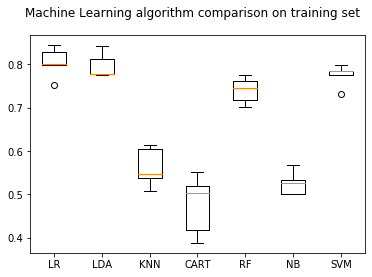

In [6]:
models = {'LR': LogisticRegression(max_iter=100, random_state=seed, tol=0.001, C=1, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed)}

warnings.filterwarnings('ignore')
results = []
names = []

for name in models.keys():
    model = models[name]
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))

fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [7]:
for key in models.keys():
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))

D:\anaconda3\envs\DS4400\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[RESULT] LR accuracy on training set: 1.000
[RESULT] LR accuracy on testing set: 0.773
[RESULT] LDA accuracy on training set: 0.949
[RESULT] LDA accuracy on testing set: 0.807
[RESULT] KNN accuracy on training set: 0.665
[RESULT] KNN accuracy on testing set: 0.588
[RESULT] CART accuracy on training set: 1.000
[RESULT] CART accuracy on testing set: 0.454
[RESULT] RF accuracy on training set: 1.000
[RESULT] RF accuracy on testing set: 0.731
[RESULT] NB accuracy on training set: 0.560
[RESULT] NB accuracy on testing set: 0.622
[RESULT] SVM accuracy on training set: 0.964
[RESULT] SVM accuracy on testing set: 0.782


### Best model: Random Froest
We build some examples using random forest model.

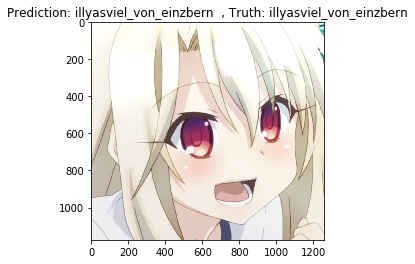

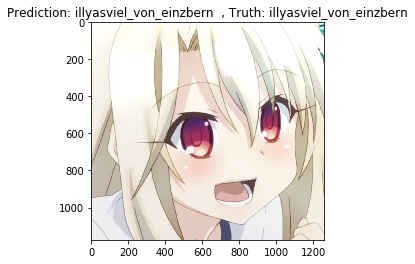

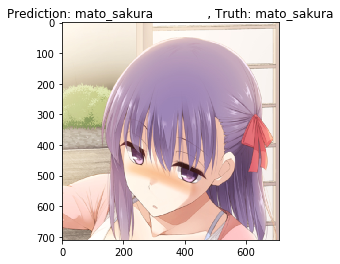

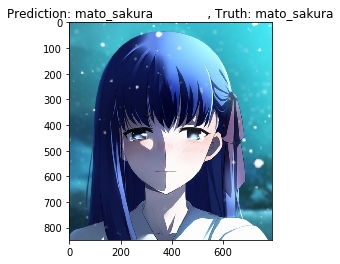

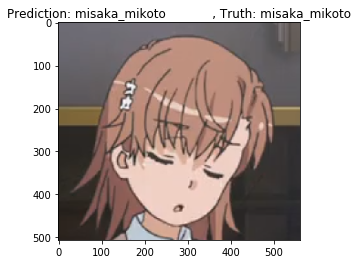

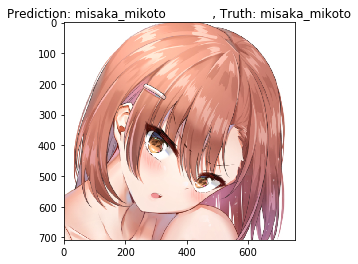

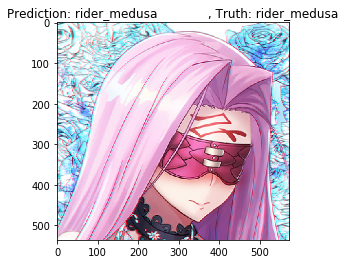

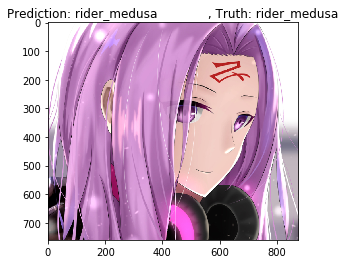

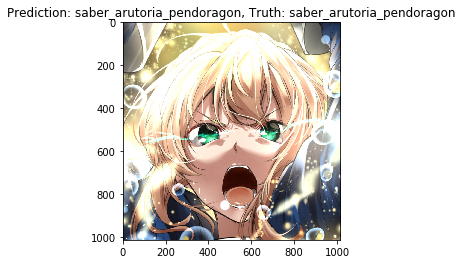

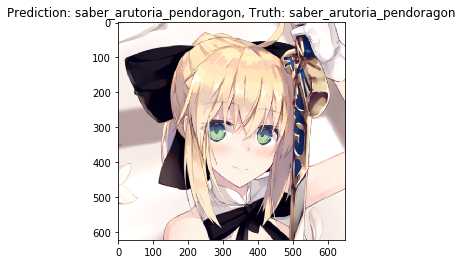

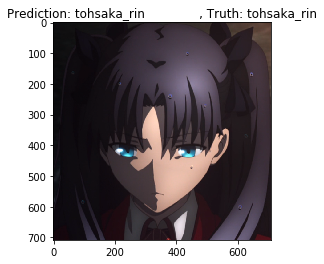

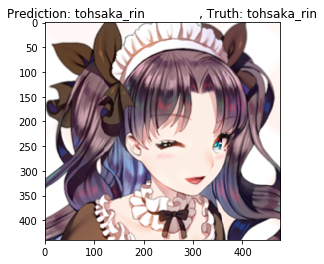

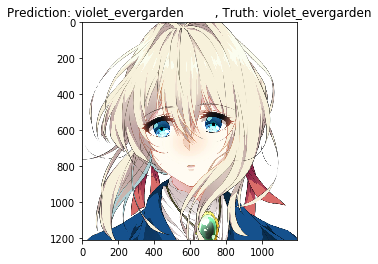

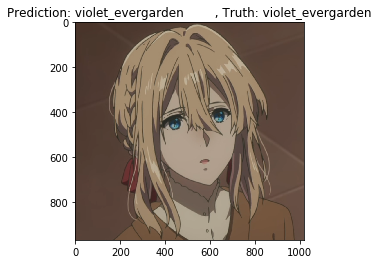

In [11]:
best_model = models['LDA']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.single_rgb(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()